# Trained the pretrained weight

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras import backend as K
# os.environ["CUDA_VISIBLE_DEVICES"] = '3'
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, Lambda, Dropout
from keras.layers import LeakyReLU, Multiply, add, dot, SeparableConv2D, DepthwiseConv2D, Reshape, Add
from keras.regularizers import l2
from keras.models import Model, load_model, model_from_json
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from keras import regularizers
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
from PIL import Image
from tqdm import tqdm, trange
import random

Using TensorFlow backend.


In [2]:
nb_classes = 1  # number of classes
img_width, img_height = 64, 64  # change based on the shape/structure of your images
batch_size = 32  # try 4, 8, 16, 32, 64, 128, 256 dependent on CPU/GPU memory capacity (powers of 2 values).
nb_epoch = 50  # number of iteration the algorithm gets trained.
learn_rate = 1e-5  # sgd learning rate

# Dir

In [3]:
train_dir = '/home/www/fake_detection/task2/128x128/train'
validation_dir = '/home/www/fake_detection/task2/128x128/validation'
test50_dir = '/home/www/fake_detection/task2/128x128/test_50'

# ShallowNet

In [4]:
# ShallowNet V3
img_input = Input(shape=(img_height, img_width, 3))

# block 1
x = Conv2D(32, (5, 5), padding='valid', kernel_regularizer=regularizers.l2(0.0001))(img_input)
x = Activation('relu')(x)
x = Dropout(0.25)(x)
x = Conv2D(32, (1, 1), kernel_regularizer=regularizers.l2(0.0001))(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)
x = Conv2D(32, (1, 1), kernel_regularizer=regularizers.l2(0.0001))(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

# block 2
x = Conv2D(64, (3, 3), padding='valid', kernel_regularizer=regularizers.l2(0.0001))(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)
x = Conv2D(64, (1, 1), kernel_regularizer=regularizers.l2(0.0001))(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)
x = Conv2D(64, (1, 1), kernel_regularizer=regularizers.l2(0.0001))(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

# block 3
x = Conv2D(128, (3, 3), padding='valid', kernel_regularizer=regularizers.l2(0.0001))(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)
x = Conv2D(32, (1, 1), kernel_regularizer=regularizers.l2(0.0001))(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)

# block 4
x = Flatten()(x)
x_de = Dense(1024, kernel_regularizer=regularizers.l2(0.0001))(x)
x_rl = Activation('relu')(x_de)
x_bn = BatchNormalization()(x_rl)
x_dp = Dropout(0.25)(x_bn)

x_sig = Dense(2, activation=None)(x_dp)
out = Activation('sigmoid')(x_sig)

model = Model(img_input, out)
print("Loaded Model from disk")
print(model.summary())


Loaded Model from disk
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        2432      
_________________________________________________________________
activation_1 (Activation)    (None, 60, 60, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        1056      
_________________________________________________________________
activation_2 (Activation)    (None, 60, 60, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None,

In [5]:
# model = load_model("/home/www/fake_detection/model/pretrained/SNv3_3.h5")

In [6]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(len(model.trainable_weights))

22


# Data generator

In [7]:
train_datagen = ImageDataGenerator(rotation_range=0.2, 
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=2,
                                   height_shift_range=2,
                                   horizontal_flip=True,
                                   rescale=1./255,)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(validation_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        shuffle=False,
                                                        class_mode='categorical')

test50_generator = test_datagen.flow_from_directory(test50_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 128404 images belonging to 2 classes.
Found 32100 images belonging to 2 classes.
Found 37566 images belonging to 2 classes.


In [8]:
callback_list = [EarlyStopping(monitor='val_accuracy', patience=50),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)]
history = model.fit_generator(train_generator,
                            steps_per_epoch=200,
                            epochs=50,
                            validation_data=validation_generator,
                            validation_steps=len(validation_generator),
                            callbacks=callback_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/50
200/200 [==============================] - 88s 439ms/step - loss: 0.7966 - accuracy: 0.7100 - val_loss: 0.7090 - val_accuracy: 0.5000
Epoch 2/50
200/200 [==============================] - 83s 413ms/step - loss: 0.6483 - accuracy: 0.7839 - val_loss: 1.1706 - val_accuracy: 0.5000
Epoch 3/50
200/200 [==============================] - 84s 422ms/step - loss: 0.6072 - accuracy: 0.7873 - val_loss: 0.6608 - val_accuracy: 0.9716
Epoch 4/50
200/200 [==============================] - 82s 411ms/step - loss: 0.5694 - accuracy: 0.7873 - val_loss: 0.6045 - val_accuracy: 0.9611
Epoch 5/50
200/200 [==============================] - 85s 425ms/step - loss: 0.5621 - accuracy: 0.7877 - val_loss: 0.5208 - val_accuracy: 0.9734
Epoch 6/50
200/200 [==============================] - 84s 421ms/step - loss: 0.5439 - accuracy: 0.7898 - val_loss: 0.6890 - val_accuracy: 0.8864
Epoch 7/50
200/200 [===============

In [15]:
# ShallowNet V3
img_input = Input(shape=(img_height, img_width, 3))

# block 1
x = Conv2D(32, (5, 5), padding='valid', kernel_regularizer=regularizers.l2(0.0001))(img_input)
x = Activation('relu')(x)
x = Dropout(0.25)(x)
x = Conv2D(32, (1, 1), kernel_regularizer=regularizers.l2(0.0001))(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)
x = Conv2D(32, (1, 1), kernel_regularizer=regularizers.l2(0.0001))(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

# block 2
x = Conv2D(64, (3, 3), padding='valid', kernel_regularizer=regularizers.l2(0.0001))(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)
x = Conv2D(64, (1, 1), kernel_regularizer=regularizers.l2(0.0001))(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)
x = Conv2D(64, (1, 1), kernel_regularizer=regularizers.l2(0.0001))(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

# block 3
x = Conv2D(128, (3, 3), padding='valid', kernel_regularizer=regularizers.l2(0.0001))(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)
x = Conv2D(32, (1, 1), kernel_regularizer=regularizers.l2(0.0001))(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)

# block 4
x = Flatten()(x)
x_sig = Dense(2, activation=None)(x)
out = Activation('softmax')(x_sig)

model = Model(img_input, out)
print("Loaded Model from disk")
print(model.summary())

Loaded Model from disk
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 60, 60, 32)        2432      
_________________________________________________________________
activation_20 (Activation)   (None, 60, 60, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 60, 60, 32)        1056      
_________________________________________________________________
activation_21 (Activation)   (None, 60, 60, 32)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 

In [16]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(len(model.trainable_weights))

18


In [17]:
callback_list = [EarlyStopping(monitor='val_accuracy', patience=50),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)]
history_tune = model.fit_generator(train_generator,
                            steps_per_epoch=200,
                            epochs=50,
                            validation_data=validation_generator,
                            validation_steps=len(validation_generator),
                            callbacks=callback_list)

Epoch 1/50
200/200 [==============================] - 67s 337ms/step - loss: 0.6518 - accuracy: 0.6275 - val_loss: 0.7629 - val_accuracy: 0.5098
Epoch 2/50
200/200 [==============================] - 69s 346ms/step - loss: 0.5065 - accuracy: 0.7630 - val_loss: 0.8829 - val_accuracy: 0.5387
Epoch 3/50
200/200 [==============================] - 69s 346ms/step - loss: 0.4825 - accuracy: 0.7816 - val_loss: 0.8489 - val_accuracy: 0.7783
Epoch 4/50
200/200 [==============================] - 69s 347ms/step - loss: 0.4674 - accuracy: 0.7920 - val_loss: 0.6965 - val_accuracy: 0.8275
Epoch 5/50
200/200 [==============================] - 69s 343ms/step - loss: 0.4564 - accuracy: 0.7928 - val_loss: 0.5504 - val_accuracy: 0.9689
Epoch 6/50
200/200 [==============================] - 69s 345ms/step - loss: 0.4513 - accuracy: 0.7980 - val_loss: 0.6345 - val_accuracy: 0.9712
Epoch 7/50
200/200 [==============================] - 67s 335ms/step - loss: 0.4478 - accuracy: 0.7980 - val_loss: 0.4384 - val_ac

<Figure size 360x288 with 0 Axes>

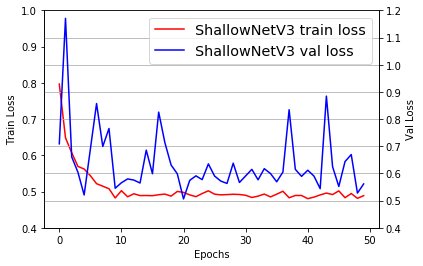

In [74]:
plt.figure(figsize = (5, 4))
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
line1 = ax1.plot(history.history['loss'], 'r', label='ShallowNetV3 train loss')
line2 = ax2.plot(history.history['val_loss'], 'b', label='ShallowNetV3 val loss')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Train Loss")
ax2.set_ylabel("Val Loss")
ax1.set_ylim(0.4, 1.0)
ax2.set_ylim(0.4, 1.2)
lines = line1 + line2
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, fontsize='x-large')
plt.grid()

In [75]:
fig.savefig("fig1.png", dpi=1000)

<Figure size 360x288 with 0 Axes>

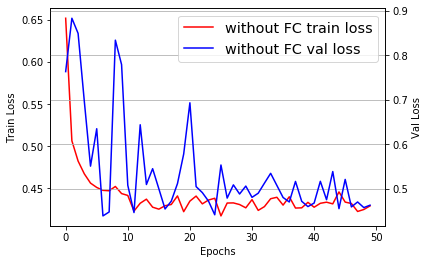

In [76]:
plt.figure(figsize = (5, 4))
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
line1 = ax1.plot(history_tune.history['loss'], 'r', label='without FC train loss')
line2 = ax2.plot(history_tune.history['val_loss'], 'b', label='without FC val loss')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Train Loss")
ax2.set_ylabel("Val Loss")
lines = line1 + line2
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, fontsize='x-large')
plt.grid()

In [ ]:
fig.savefig("fig2.png", dpi=1000)

In [12]:
output = model.predict_generator(test50_generator, steps=len(test50_generator), verbose=1)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(test50_generator.class_indices)
print(output)

1174/1174 [==============================] - 21s 18ms/step
{'0_real': 0, '1_fake': 1}
[[0.952 0.048]
 [0.870 0.130]
 [0.719 0.281]
 ...
 [0.477 0.523]
 [0.313 0.687]
 [0.385 0.615]]


In [13]:
output_score50 = []
output_class50 = []
answer_class50 = []
answer_class50_1 =[]

for i in trange(len(test50_generator)):
    output50 = model.predict_on_batch(test50_generator[i][0])
    output_score50.append(output50)
    answer_class50.append(test50_generator[i][1])
    
output_score50 = np.concatenate(output_score50)
answer_class50 = np.concatenate(answer_class50)

output_class50 = np.argmax(output_score50, axis=1)
answer_class50_1 = np.argmax(answer_class50, axis=1)

print(output_class50)
print(answer_class50_1)

100%|██████████| 1174/1174 [00:43<00:00, 26.94it/s]

[0 0 0 ... 1 1 1]
[0 0 0 ... 1 1 1]


In [14]:
cm50 = confusion_matrix(answer_class50_1, output_class50)
report50 = classification_report(answer_class50_1, output_class50)

recall50 = cm50[0][0] / (cm50[0][0] + cm50[0][1])
fallout50 = cm50[1][0] / (cm50[1][0] + cm50[1][1])

fpr50, tpr50, thresholds50 = roc_curve(answer_class50_1, output_score50[:, 1], pos_label=1.)
eer50 = brentq(lambda x : 1. - x - interp1d(fpr50, tpr50)(x), 0., 1.)
thresh50 = interp1d(fpr50, thresholds50)(eer50)

print(report50)
print(cm50)
print("AUROC: %f" %(roc_auc_score(answer_class50_1, output_score50[:, 1])))
print(thresh50)
print('test_acc: ', len(output_class50[np.equal(output_class50, answer_class50_1)]) / len(output_class50))

              precision    recall  f1-score   support

           0       0.68      0.82      0.74     18788
           1       0.77      0.61      0.68     18778

    accuracy                           0.72     37566
   macro avg       0.73      0.72      0.71     37566
weighted avg       0.73      0.72      0.71     37566

[[15442  3346]
 [ 7303 11475]]
AUROC: 0.854201
0.44834384322180254
test_acc:  0.7165255816429751
